# Train model on SageMaker notebook instance 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from space_bandits import LinearBandits, NeuralBandits 

In [2]:
os.path.join('/Users/Xiang/shuttle.txt')

'/Users/Xiang/shuttle.txt'

In [3]:
def classification_to_bandit_problem(contexts, labels, num_actions=None):
    
    if num_actions is None:
        num_actions = np.max(labels) + 1
    num_contexts = contexts.shape[0]
    
   
    contexts = contexts - np.mean(contexts, axis=0)
    
    rewards = np.zeros((num_contexts, num_actions))
    rewards[np.arange(num_contexts), labels] = 1.0
    
    return contexts, rewards, (np.ones(num_contexts), labels)

In [4]:
def sample_statlog_data(file_name, num_contexts):
    
    with open('shuttle.txt', 'r') as f:
        data = np.loadtxt(f, skiprows=1)
    
    num_actions = 7
    data = data[:num_contexts, :]
    
    contexts = data[:, :-1]
    labels = data[:, -1].astype(int) -1
    
    return classification_to_bandit_problem(contexts,labels, num_actions)

In [5]:
DATA_FILES = {'statlog': 'shuttle.txt'}

def sample_data(data_type, num_contexts):
    if data_type == 'statlog':
         
        file_name = DATA_FILES[data_type]
        num_actions = 7
        num_contexts = min(43500, num_contexts)
    
        sampled_vals = sample_statlog_data(file_name, num_contexts)
        contexts, rewards, (opt_rewards, opt_actions) = sampled_vals
        dataset = np.hstack((contexts, rewards))
        context_dim = contexts.shape[1]
    
    return dataset, opt_rewards, opt_actions, num_actions, context_dim

In [6]:
sample_data('statlog',43500)

(array([[  6.75029311,   0.20561392,   6.65824502, ...,   0.        ,
           0.        ,   0.        ],
        [  4.75029311,   0.20561392,  -3.34175498, ...,   0.        ,
           0.        ,   0.        ],
        [-11.24970689,   0.20561392,  -9.34175498, ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [ -0.24970689,   0.20561392,  -7.34175498, ...,   0.        ,
           0.        ,   0.        ],
        [ -7.24970689,   0.20561392,  -6.34175498, ...,   0.        ,
           0.        ,   0.        ],
        [ -8.24970689,  -2.79438608,  14.65824502, ...,   0.        ,
           0.        ,   0.        ]]),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([3, 0, 0, ..., 0, 0, 0]),
 7,
 9)

In [7]:
dataset, opt_rewards,opt_actions, num_actions, context_dim = sample_data('statlog',43500)

In [8]:
contexts, rewards = dataset[:,:-num_actions], dataset[:,-num_actions:]

In [9]:
rewards[1].shape

(7,)

In [10]:
linear_model = LinearBandits(num_actions,context_dim, initial_pulls=150)

In [11]:
def train(model, dataset, num_actions, steps, optimal_rewards, records=None, plot_frequency=2000, avg_length=800):
    """Goes through online learning simulation with model."""
    #these will track values for plotting
    if records is None:
        records = dict()
        records['timesteps'] = []
        records['c_reward'] = []
        records['cumulative_reward'] = 0
        records['m_reward'] = []
        records['maximum_reward'] = 0
        records['regret_record'] = []
        records['avg_regret'] = []
        records['rewards'] = []
        records['opt_rewards'] = []
        start = 0
    else:
        start = records['timesteps'][-1]
    
    
    contexts, rewards = dataset[:,:-num_actions], dataset[:,-num_actions:]
    num_contexts = len(dataset)
    
    for i in range(start,start+steps):
        records['timesteps'].append(i)
        opt_reward = optimal_rewards[i]
        context = contexts[i]
        reward = rewards[i]
        records['maximum_reward'] += opt_reward
        records['m_reward'].append(records['maximum_reward'])
        
        action = model.action(context)
        reward_taken = reward[action]
        regret = opt_reward - reward_taken
        model.update(context, action, reward_taken)
        records['rewards'].append(reward_taken)
        records['opt_rewards'].append(opt_reward)
        records['regret_record'].append(regret)
        records['cumulative_reward'] += reward_taken
        records['c_reward'].append(records['cumulative_reward'])

        #plot occasionally
        if i <= avg_length:
            if i < avg_length:
                moving_avg=0
            else:
                moving_avg = np.array(records['regret_record']).mean()
            if i == avg_length:
                records['avg_regret'] = [moving_avg] * avg_length
        else:
            moving_avg = sum(records['regret_record'][-avg_length:])/avg_length
        records['avg_regret'].append(moving_avg)
        if i % plot_frequency == 0 and i > 0:
            plot_regret(records)
            #plot_reward(records)
    return records

In [12]:
def plot_regret(records):
    c_rewardplt = np.array(records['c_reward'])/max(records['m_reward'])
    m_rewardplt = np.array(records['m_reward'])/max(records['m_reward'])
    regretplt = np.array(records['avg_regret'])/max(records['avg_regret'])
    plt.plot(records['timesteps'], c_rewardplt, label='cumulative reward')
    plt.plot(records['timesteps'], m_rewardplt, label='maximum reward')
    plt.plot(records['timesteps'], regretplt, color='red', label='mean regret')
    plt.title('Normalized Reward & Regret')
    plt.legend()
    plt.show()

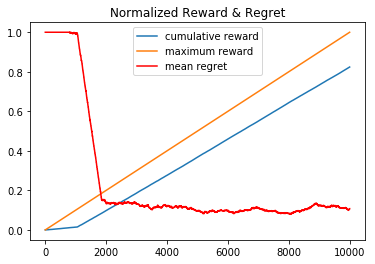

In [13]:
records = _ = train(linear_model, dataset, num_actions, 10001, opt_rewards, plot_frequency=9999)

In [52]:
num_actions=7

In [74]:
from space_bandits import load_model

linear_model.save('model_10k.pkl')
linear_model = load_model('model_10k.pkl')

# Zip model artefact and upload to S3

In [75]:
import tarfile

with tarfile.open('/Users/Xiang/model.tar.gz', 'w:gz') as f:
    t = tarfile.TarInfo('model')
    t.type = tarfile.DIRTYPE
    f.addfile(t)
    f.add('/Users/Xiang/model_10k.pkl', arcname='model_10k.pkl')

In [84]:
import sagemaker
import boto3
from sagemaker.utils import name_from_base

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

# Deploy to SageMaker

In [ ]:
role = sagemaker.get_execution_role()

In [ ]:
model=PyTorchModel(model_data=model_artefact, name=name_from_base("spacebanditswang"),
    role=role, framework_version='1.3.1',entry_point='serve.py', predictor_cls=Predictor)

predictor = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')